# Presentation du projet

## Projet : Détection des Tweets de Catastrophes

* Contexte

Twitter est un canal clé pour signaler les catastrophes en temps réel. Les organisations veulent surveiller ces alertes, mais distinguer les tweets de catastrophes réelles est complexe. Le projet utilise tweets.csv (Disaster Tweets de Kaggle) pour créer un modèle prédictif.

* Objectif

Construire un modèle ML pour prédire si un tweet annonce une catastrophe.
Développer une API de prédiction.

* Données
Fichier : tweets.csv.

* Étapes

Analyse Exploratoire :

Charger tweets.csv (pandas).
Vérifier distribution target, valeurs manquantes.
Analyser mots fréquents, hashtags, longueurs des tweets.
Nettoyer : supprimer URLs, caractères spéciaux, normaliser texte.
Feature Engineering :
Vectorisation : TF-IDF ou embeddings (BERT).
Features : longueur tweet, mots-clés, sentiment.
Encoder keyword, location si pertinents.

Modélisation :

Tester : Logistic Regression, Random Forest, BERT.
Optimiser : Grid Search, F1-score priorisé.
Interpréter : SHAP pour mots influents.
Choisir modèle final (performance/complexité).

API :

Développer (FastAPI) : POST /predict → {text: "tweet", prediction: 0/1}.
Tester robustesse.
MLOps :
Versionner sur GitHub.
Tests unitaires (preprocessing, API).

* Impact

Outil fiable pour identifier les catastrophes en temps réel, intégrable via API, maintenable grâce à MLOps.

# 1. LIBRAIRIES

Préinstaller les dépendances

In [5]:
import re
import contractions

# --- Installées
# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Traitement des données
import pandas as pd
import numpy as np

# NLP
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingClassifier


# Sauvegarde des modèles
import joblib

# Système et utilitaires
import os
from datetime import datetime
from pathlib import Path

# API et web
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
from typing import List

# Implicite 
import streamlit
import requests
import uvicorn

# Téléchargement des ressources NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Configuration des stop words
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
# Définir le répertoire de base du projet
BASE_DIR = Path.cwd()
print(f"Dossier de base : {BASE_DIR}")

# Dossier contenant les données
DATA_DIR = BASE_DIR / 'data'
print(f"Dossier de données : {DATA_DIR}")

# Dossier des résultats horodaté
RESULTS_DIR = BASE_DIR / 'results' / f"analysis_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
print(f"Dossier de résultats : {RESULTS_DIR}")

# Dossier pour sauvegarder les figures
FIGURES_DIR = RESULTS_DIR / 'figures'
print(f"Dossier de figures : {FIGURES_DIR}")

# Création des dossiers si besoin
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

Dossier de base : c:\Users\DELL\Desktop\AS3 SALIMOU\SEMESTRE 2\NLP\Tweets_catastrophes\notebooks
Dossier de données : c:\Users\DELL\Desktop\AS3 SALIMOU\SEMESTRE 2\NLP\Tweets_catastrophes\notebooks\data
Dossier de résultats : c:\Users\DELL\Desktop\AS3 SALIMOU\SEMESTRE 2\NLP\Tweets_catastrophes\notebooks\results\analysis_20250423_161453
Dossier de figures : c:\Users\DELL\Desktop\AS3 SALIMOU\SEMESTRE 2\NLP\Tweets_catastrophes\notebooks\results\analysis_20250423_161453\figures


# 2. PRÉTRAITEMENT

In [8]:
def preprocess_text(text, language="english", stopwords_list=None, normalizer="stem", 
                    remove_numbers=True, expand_contractions=True, keep_emojis=False):
    """
    Nettoie et normalise le texte .
    
    Args:
        text (str): Texte brut à prétraiter.
        language (str): Langue pour stemming/stopwords.
        stopwords_list (set): Liste de mots à supprimer.
        normalizer (str): 'stem', 'lemma' ou None pour normalisation.
        remove_numbers (bool): Supprimer les nombres.
        expand_contractions (bool): Développer les contractions (ex. "don't" -> "do not").
        keep_emojis (bool): Conserver les emojis.
    
    Returns:
        str: Texte nettoyé et normalisé.
    """
    if not isinstance(text, str) or not text.strip():
        return ""
    
    text = text.lower()
    if expand_contractions:
        text = contractions.fix(text)
    text = re.sub(r"<.*?>", "", text)  # HTML
    text = re.sub(r"(http|www)\S*", "", text)  # URL
    text = re.sub(r"\S*@\S*\s*", "", text)  # Email
    if not keep_emojis:
        text = re.sub(r"[^\w\s]", " ", text)  # Supprime ponctuation et emojis
    else:
        text = re.sub(r"[^\w\s\p{Emoji}]", " ", text, flags=re.UNICODE)  # Conserve emojis
    if remove_numbers:
        text = re.sub(r"\d+", "", text).strip()  # Numbers + trim
    
    tokens = word_tokenize(text)
    if stopwords_list:
        tokens = [word for word in tokens if word not in stopwords_list]
    
    if normalizer == "stem":
        stemmer = SnowballStemmer(language)
        tokens = [stemmer.stem(w) for w in tokens]
    elif normalizer == "lemma":
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(w) for w in tokens]
    
    return " ".join(tokens)

# 3. CHARGEMENT DES DONNÉES

In [10]:
df = pd.read_csv("data/tweets.csv") 
df = df.dropna(subset=['text', 'target'])
df['target'] = df['target'].astype(int)

# Utilisation de 'keyword' pour enrichir le texte
df['combined_text'] = df['text'] + " " + df['keyword'].fillna("")
df['cleaned_text'] = df['combined_text'].apply(lambda x: preprocess_text(x, stopwords_list=stop_words))

# Suppression des doublons et des textes vides
df = df.drop_duplicates(subset=['cleaned_text'])
df = df[df['cleaned_text'].str.strip() != '']

In [20]:
df

,id,keyword,location,text,target,combined_text,cleaned_text
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1,"Communal violence in Bhainsa, Telangana. ""Ston...",communal violenc bhainsa telangana stone pelt ...
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1,Telangana: Section 144 has been imposed in Bha...,telangana section impos bhainsa januari clash ...
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1,Arsonist sets cars ablaze at dealership https:...,arsonist set car ablaz dealership ablaz
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0,"""Lord Jesus, your love brings freedom and pard...",lord jesus love bring freedom pardon fill holi...
5,5,ablaze,OC,"If this child was Chinese, this tweet would ha...",0,"If this child was Chinese, this tweet would ha...",child chines tweet would gone viral social med...
...,...,...,...,...,...,...,...
11364,11364,wrecked,NaN,Had these guys last game n fcked them. Talked ...,0,Had these guys last game n fcked them. Talked ...,guy last game n fcked talk non stop shit n sti...
11365,11365,wrecked,Blue State in a red sea,Media should have warned us well in advance. T...,0,Media should have warned us well in advance. T...,media warn us well advanc wreck whole night re...
11366,11366,wrecked,arohaonces,i feel directly attacked 💀 i consider moonbin ...,0,i feel directly attacked 💀 i consider moonbin ...,feel direct attack consid moonbin amp jinjin b...
11368,11368,wrecked,auroraborealis,"ok who remember ""outcast"" nd the ""dora"" au?? T...",0,"ok who remember ""outcast"" nd the ""dora"" au?? T...",ok rememb outcast nd dora au au wreck nerv nd ...


# 4. EXPLORATION ET ANALYSE DES DONNÉES

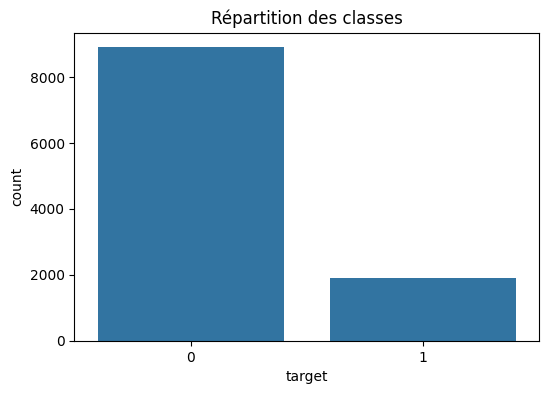

target
0    0.82366
1    0.17634
Name: proportion, dtype: float64


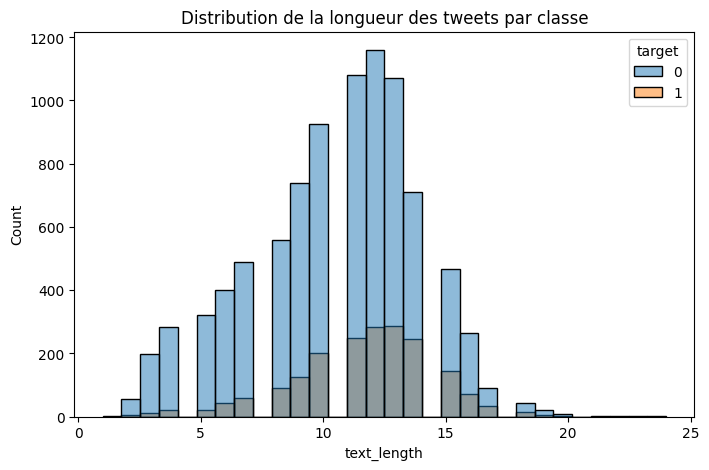

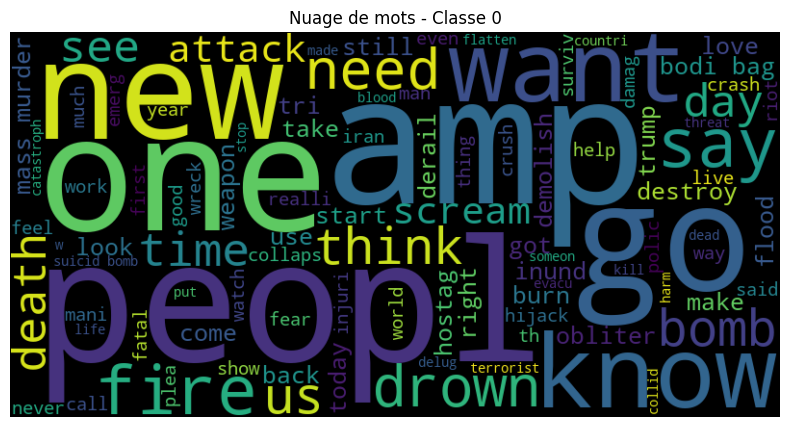

<Figure size 640x480 with 0 Axes>

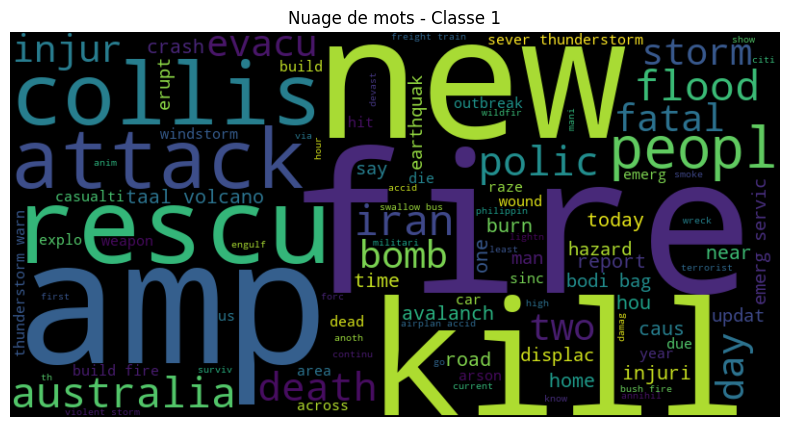

<Figure size 640x480 with 0 Axes>

In [11]:
# Distribution des classes
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df)
plt.title("Répartition des classes")
plt.show()
print(df['target'].value_counts(normalize=True))

# Distribution de la longueur des tweets
df['text_length'] = df['cleaned_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='text_length', hue='target', bins=30)
plt.title("Distribution de la longueur des tweets par classe")
plt.savefig(FIGURES_DIR / "keywords_longueur_tweets.png") # Enregistrement de la figure

plt.show()

# Nuage de mots par classe
for target in [0, 1]:
    text = " ".join(df[df['target'] == target]['cleaned_text'])
    wordcloud = WordCloud(width=800, height=400, max_words=100).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Nuage de mots - Classe {target}")
    plt.axis('off')
    plt.show()
    plt.savefig(FIGURES_DIR / "keywords_Nuage_de_mots_par_classe.png") # Enregistrement de la figure




2. Analyse des mots-clés


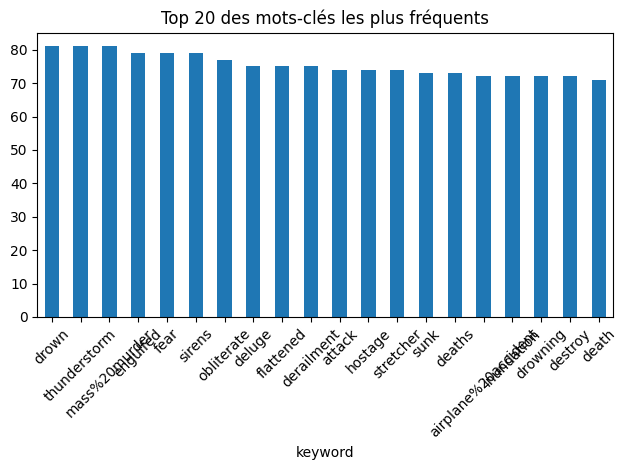

In [15]:
# Analyse des mots-clés
print("\n2. Analyse des mots-clés")
plt.figure()
keyword_counts = df['keyword'].value_counts().head(20)
keyword_counts.plot(kind='bar')
plt.title('Top 20 des mots-clés les plus fréquents')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(FIGURES_DIR / "keywords_distribution.png") # Enregistrement de la figure
plt.show()
plt.close()


3. Analyse de la longueur des tweets


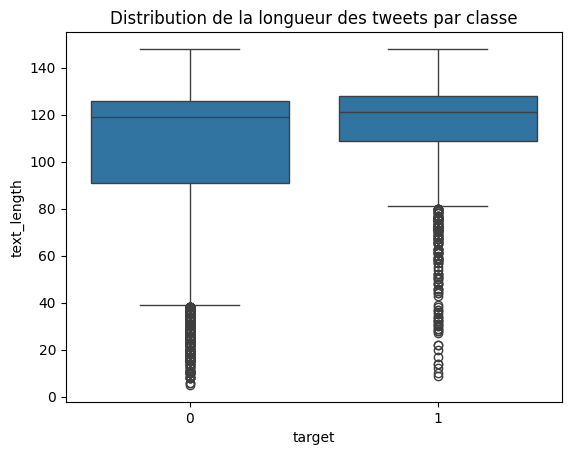

In [16]:
# Analyse de la longueur des tweets
print("\n3. Analyse de la longueur des tweets")
df['text_length'] = df['text'].str.len()

plt.figure()
sns.boxplot(data=df, x='target', y='text_length')
plt.title('Distribution de la longueur des tweets par classe')
plt.savefig(FIGURES_DIR / "tweet_length_distribution.png")
plt.show()
plt.close()

Ce qu’on observe :
Médiane similaire :

La médiane (la barre dans la boîte) est presque la même pour les deux classes, autour de 120 caractères.

Longueurs minimales similaires :

Les tweets les plus courts, dans les deux cas, tournent autour de 10 à 20 caractères.

Différences sur les extrêmes :

La classe 0 (non-désastre) montre plus de variabilité : sa boîte est plus large (écart interquartile plus grand).

La classe 1 (désastre) est plus concentrée, les tweets ont des longueurs plus homogènes.

Présence d’outliers :

Il y a pas mal de valeurs extrêmes (points noirs) dans les deux classes, surtout en bas (tweets très courts).



4. Analyse des locations


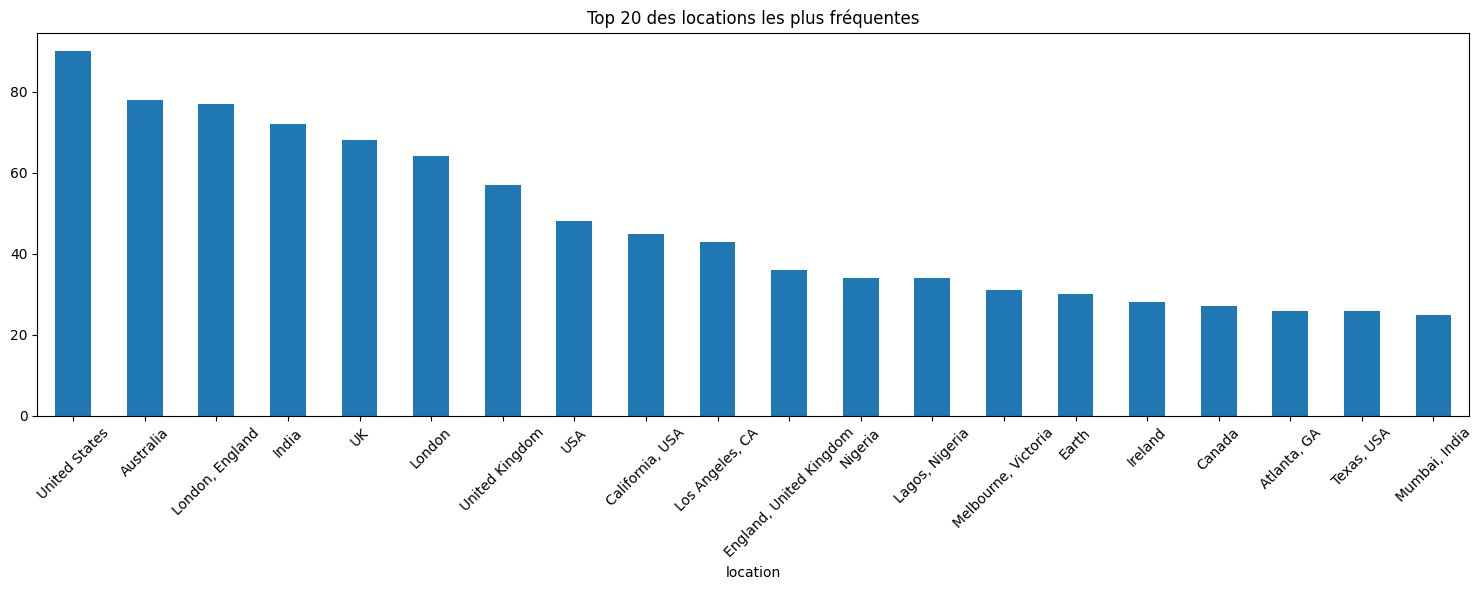

In [17]:
# Analyse des locations
print("\n4. Analyse des locations")
plt.figure(figsize=(15, 6))
df['location'].value_counts().head(20).plot(kind='bar')
plt.title('Top 20 des locations les plus fréquentes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(FIGURES_DIR / "locations_distribution.png")
plt.show()
plt.close()


Les USA dominent le classement :

United States, USA, California, USA, Texas, USA, Los Angeles, CA, Atlanta, GA → beaucoup de variantes, mais toutes liées aux États-Unis.

Suggère que la majorité des tweets proviennent des États-Unis ou que les users mettent souvent un lieu aux USA en location.

In [18]:
# Sauvegarde des données prétraitées
print("\n7. Sauvegarde des données prétraitées")
processed_df = df.copy()
processed_df['processed_text'] = processed_df['text'].apply(preprocess_text)
processed_dir = DATA_DIR / 'processed'
processed_dir.mkdir(exist_ok=True)
processed_df.to_csv(processed_dir / 'tweets_processed.csv', index=False)


7. Sauvegarde des données prétraitées
